# Interesting projects: 
* Fair Learn : https://fairlearn.org/v0.7.0/about/index.html / joint venture hugging face sklearn  https://www.linkedin.com/in/adrinjalali/?originalSubdomain=de
* Privacy internet: https://hoprnet.org/ / https://twitter.com/hoprnet/status/1564991431659458562
* Privacy Attack Deep learning: https://github.com/search?q=trailofbits%2FPrivacyRaven

* Transparency (nlp): https://github.com/PAIR-code/lit seems powered by Googlge > PAIR ?
* Fairness paper with traction ? https://github.com/xiaomi-automl/FairNAS
* false positive face recognition for gender, race etc : https://github.com/serengil/deepface


In [3]:
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [58]:
from github import Github

# using an access token
g = Github("YOUR ACCESS TOKEN HERE") #

#Github Enterprise with custom hostname
#g = Github(base_url="https://{hostname}/api/v3", login_or_token="access_token")

In [73]:
g.get_rate_limit()

RateLimit(core=Rate(reset=2022-10-24 16:45:52, remaining=3167, limit=5000))

### key features

repo:
* id: `id`
* full name: `full_name`
* nb stars: `stargazers_count`
* nb watchers: `watchers_count`
* description: `description`
* topics: `topics`
* nb forks: `forks_count`
* language: `language`
* visibility: `visibility`
* nb subscribers: `subscribers_count`
* nb open issues: `open_issues_count`
* creation date : `created_at`
* last modified date: `last_modified`
* has projects : `has_projects`
* has wiki : `has_wiki`
* has downloads : `has_downloads`

owner:
* id: `id`
* name: `name`
* login: `login`
* type: `type` (ex: User)
* bio: `bio`
* company: `company`
* role: `role`
* email: `email`
* followers: `followers`
* following: `following`
* location: `location`
* nb private repos: `total_private_repos`
* nb public_repos: `public_repos`
* team count : `team_count`
* twitter_username: `twitter_username`
* creation date : `created_at`

* organization followers
* last updated
* licensing
* most used topics 

In [54]:
PRIVACY = "privacy"
FAIRNESS = "fairness"
TRANSPARENCY = "transparency"
MISUSE = "misuse"
SUSTAINABILITY = "sustainability"
RISK_ASSESSMENT = "risk assessment"
ETHICS_AND_LEGAL = "Ethics of scale"
TAXONOMY = {
    PRIVACY: [
        "privacy", "data privacy", "data protection","differential privacy", "privacy attack", "privacy protection", "information security"
    ],
    FAIRNESS: [
        "fairness", "algorithmic bias", "bias in AI", "gender bias", "ethnicity bias", "sexual orientation bias",
        "disability", "parity", "equality", "opportunity" 
    ],
    TRANSPARENCY: [
        "Explicability", "Explainable AI", "AI interpretability", "Model interpretability", "transparency in AI", "model explicability",
        "transparency machine learning", 
    ],
    MISUSE: [
        "AI misuse","Adversarial Attacks", "Deep Fakes", "Fake News", "Arming Image Generation", "Machine Learning Model Misuse",
        "Language Model misuse", "Prompt Engineering"
    ],
    SUSTAINABILITY: [
        "AI sustainability", "Sustainable AI", "AI for Climate", "AI carbon emission"
    ],
    ETHICS_AND_LEGAL: [
        "Ethics of scale AI", "AI regulation", "AI Robots rights", "AI Legality"
    ]
}

SUFFIX = "suffix"
REPOSITORY = "repository"
OWNER = "owner"
ORGANIZATION = "organization"
ATTRIBUTES = "attributes"
GITHUB_DATA = {
    REPOSITORY: {
        SUFFIX: "repo_",
        ATTRIBUTES: ["id", "full_name", "stargazers_count", "watchers_count", "description",
             "topics", "forks_count", "language", "visibility", "subscribers_count", "open_issues_count",
             "created_at", "last_modified", "has_projects", "has_wiki", "has_downloads", "size", "raw_data"]
    },
    OWNER: {
        SUFFIX: "owner_",
        ATTRIBUTES: [
            "id", "name", "login", "type", "bio", "company", "role", "email", "followers", "following", "location", "total_private_repos",
            "public_repos", "team_count", "twitter_username", "created_at", "updated_at","raw_data"
        ]
        
    },
    ORGANIZATION: {
        SUFFIX: "orga_",
        ATTRIBUTES: [
             "id", "name", "login", "type","description", "company", "email", "followers", "following", "location", "total_private_repos",
            "public_repos", "collaborators", "created_at", "updated_at","blog", "raw_data"
        ]
    }
}


In [70]:

def get_column_names(github_data=GITHUB_DATA):
    return [data[SUFFIX]+column for level, data in GITHUB_DATA.items() for column in data[ATTRIBUTES]]

def create_record(entity, properties: list) -> list:
    """return a list of properties contained in the entity passed in parameter"""
    return [getattr(entity, property_) for property_ in properties]

def collect_data_from_repositories(repositories, github_data=GITHUB_DATA, n_top=50, repo_ids={}):
    data = []
    for repo in repositories[:n_top]:
        repo_id = repo.id
        if repo_id in repo_ids:
            print(repo_id,"already collected")
            continue
        repo_data = create_record(repo, github_data[REPOSITORY].get(ATTRIBUTES))
        owner_data = create_record(repo.owner, github_data[OWNER].get(ATTRIBUTES))
        if repo.organization: 
            organization_data = create_record(repo.organization, github_data[ORGANIZATION].get(ATTRIBUTES))
        else:
            # fill with nan
            organization_data = [None] * len(GITHUB_DATA[ORGANIZATION][ATTRIBUTES])
        record = repo_data + owner_data + organization_data
        data.append(record)

    return pd.DataFrame(data, columns=get_column_names())

def get_repo_ids(data):
    if data is None:
        repo_ids = []
    else: 
        repo_ids = data.repo_id.unique().tolist()
    return {e: None for e in repo_ids}


def collect_github_data(limit_per_query=10, repo_ids={}):
    data = pd.DataFrame()
    for taxo_category, queries in TAXONOMY.items():
        for query in queries[:limit_per_query]:
            print(query)
            # NOTE: add try except here to avoid losing data when too many requests are send
            repositories = g.search_repositories(query=query)
            current_repos = collect_data_from_repositories(repositories, repo_ids=repo_ids)
            current_repos["taxo_category"] = taxo_category
            current_repos["query"] = query
            data = pd.concat([data, current_repos], ignore_index=True)
            repo_ids.update(get_repo_ids(data))
    return data

pre_collected_repo = pd.read_csv("./../experiments.save.csv", delimiter=",", index_col=0)
repo_ids = get_repo_ids(pre_collected_repo)
data = collect_github_data(repo_ids=repo_ids)

privacy
316099858 already collected
162747292 already collected
13595305 already collected
195766483 already collected
11321096 already collected
428203208 already collected
41654081 already collected
319261190 already collected
38752754 already collected
20446681 already collected
206320938 already collected
82708632 already collected
911765 already collected
206106232 already collected
12888993 already collected
109179063 already collected
21967024 already collected
67837600 already collected
512269935 already collected
318401906 already collected
101590155 already collected
113626207 already collected
231104091 already collected
152788528 already collected
123220152 already collected
209767110 already collected
113919648 already collected
20693743 already collected
82502054 already collected
192547145 already collected
99481058 already collected
73670742 already collected
95905717 already collected
235434204 already collected
36928490 already collected
67874380 already collected
115

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


195766483 already collected
19502992 already collected
235770174 already collected
123631418 already collected
138918849 already collected
136032952 already collected
85519074 already collected
128634700 already collected
132129752 already collected
173828496 already collected
379945592 already collected
459733233 already collected
4008931 already collected
131279485 already collected
362347312 already collected
352102683 already collected
492668666 already collected
120921410 already collected
41149350 already collected
392596701 already collected
13223163 already collected
90122676 already collected
94246723 already collected
124251337 already collected
321521196 already collected
85144295 already collected
477575374 already collected
21832315 already collected
88062408 already collected
220928179 already collected
109798785 already collected
453168821 already collected
398163837 already collected
139376543 already collected
184398990 already collected
141151511 already collected
389

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)
/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


fairness
252939699 already collected
121427697 already collected
211972484 already collected
133444044 already collected
200863357 already collected
193215554 already collected
233680441 already collected
81018196 already collected
215361399 already collected
194769649 already collected
119049129 already collected
105919803 already collected
145761123 already collected
4957 already collected
75526722 already collected
217433767 already collected
203465734 already collected
138831170 already collected
180605180 already collected
174024629 already collected
200430755 already collected
27432740 already collected
267900977 already collected
66581808 already collected
162270942 already collected
101510799 already collected
149060072 already collected
221494150 already collected
246503079 already collected
265919254 already collected
276493242 already collected
148630592 already collected
210951915 already collected
56298306 already collected
141272624 already collected
174230194 already col

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


172849438 already collected
145761123 already collected
16213069 already collected
265919254 already collected
141727944 already collected
124103906 already collected
38612481 already collected
232093431 already collected
168850558 already collected
167136127 already collected
219865447 already collected
140516142 already collected
217588478 already collected
112201533 already collected
99464772 already collected
43238746 already collected
329636396 already collected
38817800 already collected
101478427 already collected
290530005 already collected
108594418 already collected
444896012 already collected
278192496 already collected
157635094 already collected
91729345 already collected
165450285 already collected
365684111 already collected
187394703 already collected
392828154 already collected
77652378 already collected
283214088 already collected
234091682 already collected
58110488 already collected
389551693 already collected
380382052 already collected
539955546 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


145761123 already collected
215361399 already collected
184704903 already collected
434304373 already collected
329636396 already collected
367614997 already collected
283214088 already collected
181447791 already collected
355131778 already collected
339145668 already collected
164884435 already collected
215558812 already collected
264507535 already collected
265936663 already collected
353769942 already collected
136576160 already collected
135765077 already collected
355097747 already collected
194959554 already collected
135639964 already collected
436936539 already collected
146149799 already collected
264229354 already collected
352620694 already collected
140501864 already collected
364013500 already collected
467664461 already collected
494184828 already collected
254222539 already collected
358273865 already collected
332325671 already collected
399751447 already collected
364331344 already collected
315965877 already collected
355131203 already collected
339031855 already co

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


77336565 already collected
122248350 already collected
354019245 already collected
124103906 already collected
112201533 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


ethnicity bias
139335423 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


sexual orientation bias
139335423 already collected
193362077 already collected
384607757 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


disability


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


parity


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


equality
124920933 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


opportunity


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Explicability
492871434 already collected
148420967 already collected
368963467 already collected
233439643 already collected
278094596 already collected
378766228 already collected
147531125 already collected
493797155 already collected
225835890 already collected
486341090 already collected
424634210 already collected
484344111 already collected
338382674 already collected
105771336 already collected
483137630 already collected
408996367 already collected
421181454 already collected
177558355 already collected
Explainable AI


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


240843379 already collected
196340907 already collected
285236885 already collected
460340490 already collected
242097396 already collected
184704903 already collected
283726165 already collected
218478064 already collected
92983437 already collected
349116466 already collected
165302201 already collected
166231682 already collected
256050306 already collected
199751413 already collected
221019945 already collected
188701024 already collected
153565978 already collected
268872911 already collected
540765073 already collected
250238223 already collected
374163030 already collected
403595389 already collected
445610976 already collected
144536553 already collected
352535620 already collected
272729720 already collected
286297980 already collected
174995387 already collected
343799272 already collected
362744725 already collected
416921348 already collected
190691365 already collected
346208949 already collected
335700054 already collected
350589371 already collected
326984683 already col

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


196340907 already collected
107597829 already collected
184704903 already collected
351354197 already collected
172362292 already collected
277645425 already collected
240843379 already collected
92983437 already collected
220637514 already collected
215361399 already collected
285236885 already collected
195266931 already collected
276973067 already collected
221019945 already collected
349116466 already collected
406280658 already collected
188701024 already collected
343799272 already collected
68553801 already collected
141081019 already collected
283726165 already collected
321699588 already collected
411403506 already collected
142799625 already collected
172495473 already collected
326984683 already collected
304808535 already collected
272729720 already collected
503108051 already collected
165302201 already collected
355654613 already collected
366483356 already collected
244340408 already collected
355586140 already collected
337430397 already collected
477144804 already coll

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


204734444 already collected
184704903 already collected
196340907 already collected
283215238 already collected
196956879 already collected
74505259 already collected
10329313 already collected
153726963 already collected
172687028 already collected
125130145 already collected
134582074 already collected
184467039 already collected
105082109 already collected
289776866 already collected
362644964 already collected
129926993 already collected
259856594 already collected
195266931 already collected
85300689 already collected
228166521 already collected
52333038 already collected
131170912 already collected
451631516 already collected
174432286 already collected
110891022 already collected
100581007 already collected
60218942 already collected
140207339 already collected
453053593 already collected
196159953 already collected
116845350 already collected
66490786 already collected
486898701 already collected
111768473 already collected
390359611 already collected
272459149 already collecte

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


184704903 already collected
142799625 already collected
363133577 already collected
477944284 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


model explicability
233439643 already collected
338382674 already collected
transparency machine learning


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


184704903 already collected
125130145 already collected
259856594 already collected
107597829 already collected
101510799 already collected
272729720 already collected
363133577 already collected
240320232 already collected
142406113 already collected
326728303 already collected
529567737 already collected
319040177 already collected
AI misuse


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)
/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Adversarial Attacks
283726165 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Deep Fakes


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Fake News
121196889 already collected
172204804 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Arming Image Generation


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Machine Learning Model Misuse
182211058 already collected
308097038 already collected
Language Model misuse


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


182211058 already collected
308097038 already collected
Prompt Engineering


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)
/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI sustainability


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Sustainable AI
533452400 already collected
87838685 already collected
459237135 already collected
181844667 already collected
474426455 already collected
178518637 already collected
359187291 already collected
468860202 already collected
58397310 already collected
207625679 already collected
182497541 already collected
547213721 already collected
525776088 already collected
310416830 already collected
55378656 already collected
499007070 already collected
73875463 already collected
535134794 already collected
298649282 already collected
416455210 already collected
427934418 already collected
62177786 already collected
519035050 already collected
160915044 already collected
73835607 already collected
30957871 already collected
417795326 already collected
490576322 already collected
273920856 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI for Climate
366585162 already collected
474426455 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI carbon emission


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


Ethics of scale AI


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI regulation
181447791 already collected
319040177 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI Robots rights
308097038 already collected


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


AI Legality


/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/2930197042.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data = pd.concat([data, current_repos], ignore_index=True)


In [72]:
data.to_pickle("new_data.save.pkl")

In [76]:
def consolidate_data(old_data, new_data):
    if old_data.shape[1] != new_data.shape[1]:
        print("can't concat check column shape")
    
    return pd.concat([old_data, new_data], ignore_index=True)
    
repositories = consolidate_data(pre_collected_repo, data)

/var/folders/d0/b9m4_qw54wz6zkfclgxdnvw40000gn/T/ipykernel_13042/818918258.py:5: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat([old_data, new_data], ignore_index=True)


In [77]:
repositories.shape

(2130, 55)

In [82]:
repositories["taxo_category"].value_counts()

fairness           765
privacy            586
transparency       386
misuse             214
sustainability     127
Ethics of scale     52
Name: taxo_category, dtype: int64

In [88]:
repositories.to_csv("experiments.save.csv")

In [155]:
TARGET_DIR = os.path.abspath("./data/github/")

## Scoring

### Filters 
- no code (filter where language is none)
- less than 5 stars 

Scores:
standardize then sum 
- positive: stars, forks, issues, repo_size, max(owner followers, orga followers), max(orga public repos, owner public repos)
- negative: big company

In [89]:
candidates = repositories.drop_duplicates(["repo_id"]).copy()
candidates.repo_language.value_counts()

Python              558
Jupyter Notebook    450
JavaScript          137
HTML                 83
Java                 49
C++                  45
R                    41
Rust                 38
C#                   38
TypeScript           32
CSS                  26
C                    24
Go                   23
Ruby                 22
PHP                  22
Shell                22
TeX                  16
MATLAB               10
Dart                  8
Objective-C           8
Swift                 7
Julia                 6
Vue                   5
Kotlin                5
Haskell               4
Matlab                4
Scala                 4
Dockerfile            3
SCSS                  3
Batchfile             3
PowerShell            3
Lua                   3
PureScript            2
Solidity              2
CoffeeScript          2
Clojure               2
Assembly              2
Tcl                   2
Bicep                 2
Pug                   2
Elixir                2
OCaml           

In [112]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

MIN_STARS = 5

def filter_candidates(candidates, min_stars=MIN_STARS):
    black_list = ["Microsoft","Meta Research", "Google", "BCG Gamma", "Amazon", "IBM", "salesforce"]
    retained_langugages = ["Python", "C++", "R", "Java", "TypeScript", "Julia", "Scala", "MATLAB", "C", ]

    regex_black_list = "*|".join(black_list) + "*"
    mask = (
        (candidates["repo_stargazers_count"] > 5) 
        & ~(candidates.orga_name.str.contains(regex_black_list, na=False))
        & ~candidates.repo_language.isnull()
        & (candidates.repo_language.isin(retained_langugages))
    )
    return candidates[mask].drop_duplicates(["repo_id"])


def create_years_since_creation(candidates):
    return candidates.assign(
        **{
        "repo_years_since_creation":(pd.Timestamp.today() - candidates.repo_created_at).dt.days/365
    }
    )


def score_candidates(candidates):
    features = ["repo_stargazers_count", "repo_forks_count", "repo_size", "owner_followers", "owner_public_repos"]
    X = candidates[features].copy()
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=features, index=X.index)
    X["score"] = X.sum(axis=1)
    candidates = candidates.merge(X[["score"]], left_index=True, right_index=True)
    return candidates

def cast(candidates):
    candidates.repo_created_at = pd.to_datetime(candidates.repo_created_at)
    return candidates

candidates = repositories.copy()
candidates = candidates.pipe(cast).pipe(filter_candidates).pipe(score_candidates)

In [113]:
import matplotlib 
repositories.repo_stargazers_count.quantile(0.5)

14.0

In [114]:
candidates = create_years_since_creation(candidates)
candidates.sort_values(by="score", ascending=False)

,repo_id,repo_full_name,repo_stargazers_count,repo_watchers_count,repo_description,repo_topics,repo_forks_count,repo_language,repo_visibility,repo_subscribers_count,repo_open_issues_count,repo_created_at,repo_last_modified,repo_has_projects,repo_has_wiki,repo_has_downloads,repo_size,repo_raw_data,owner_id,owner_name,owner_login,owner_type,owner_bio,owner_company,owner_role,owner_email,owner_followers,owner_following,owner_location,owner_total_private_repos,owner_public_repos,owner_team_count,owner_twitter_username,owner_created_at,owner_updated_at,owner_raw_data,orga_id,orga_name,orga_login,orga_type,orga_description,orga_company,orga_email,orga_followers,orga_following,orga_location,orga_total_private_repos,orga_public_repos,orga_collaborators,orga_created_at,orga_updated_at,orga_blog,orga_raw_data,taxo_category,query,score,repo_years_since_creation
14,12888993,home-assistant/core,55384,55384,:house_with_garden: Open source home automatio...,"['asyncio', 'hacktoberfest', 'home-automation'...",20091,Python,public,1348,2064,2013-09-17 07:29:48,"Thu, 20 Oct 2022 13:53:05 GMT",True,False,True,387135,"{'id': 12888993, 'node_id': 'MDEwOlJlcG9zaXRvc...",13844975,Home Assistant,home-assistant,Organization,Open source home automation that puts local co...,NaN,NaN,hello@home-assistant.io,1787,0,Your home,NaN,92,NaN,home_assistant,2015-08-18 04:27:28,2022-10-04 11:17:05,"{'login': 'home-assistant', 'id': 13844975, 'n...",13844975.0,Home Assistant,home-assistant,Organization,NaN,NaN,hello@home-assistant.io,1787.0,0.0,Your home,NaN,92.0,NaN,2015-08-18 04:27:28,2022-10-04 11:17:05,https://www.home-assistant.io,"{'login': 'home-assistant', 'id': 13844975, 'n...",privacy,privacy,2.305828,9.106849
1374,162723104,OWASP/CheatSheetSeries,21946,21946,The OWASP Cheat Sheet Series was created to pr...,"[application-security, appsec, best-practices,...",3165,Python,public,524,30,2018-12-21 14:26:43,"Mon, 24 Oct 2022 15:04:30 GMT",True,False,True,1139565,"{'id': 162723104, 'node_id': 'MDEwOlJlcG9zaXRv...",155815,OWASP,OWASP,Organization,The OWASP Foundation,None,NaN,admin@owasp.com,1520,0,None,NaN,982,NaN,None,2009-11-20 06:56:22,2022-10-11 11:05:42,"{'login': 'OWASP', 'id': 155815, 'node_id': 'M...",155815.0,OWASP,OWASP,Organization,NaN,NaN,admin@owasp.com,1520.0,0.0,None,NaN,982.0,NaN,2009-11-20 06:56:22,2022-10-11 11:05:42,https://owasp.org,"{'login': 'OWASP', 'id': 155815, 'node_id': 'M...",privacy,information security,1.448282,3.843836
200,35866694,RocketChat/Rocket.Chat,33589,33589,The communications platform that puts data pro...,"['chat', 'collaboration', 'foss', 'free', 'hac...",7670,TypeScript,public,904,3508,2015-05-19 07:36:09,"Thu, 20 Oct 2022 13:56:56 GMT",True,True,True,633207,"{'id': 35866694, 'node_id': 'MDEwOlJlcG9zaXRvc...",12508788,Rocket.Chat,RocketChat,Organization,The communications platform that puts data pro...,NaN,NaN,NaN,366,0,NaN,NaN,237,NaN,NaN,2015-05-19 07:33:29,2022-02-18 13:58:03,"{'login': 'RocketChat', 'id': 12508788, 'node_...",12508788.0,Rocket.Chat,RocketChat,Organization,NaN,NaN,NaN,366.0,0.0,NaN,NaN,237.0,NaN,2015-05-19 07:33:29,2022-02-18 13:58:03,https://rocket.chat,"{'login': 'RocketChat', 'id': 12508788, 'node_...",privacy,data protection,1.429793,7.438356
1386,245961846,PacktPublishing/Python-for-Automating-Informat...,17,17,None,[],22,Python,public,4,0,2020-03-09 06:39:43,"Sat, 22 Oct 2022 23:55:09 GMT",False,True,True,10264,"{'id': 245961846, 'node_id': 'MDEwOlJlcG9zaXRv...",10974906,Packt,PacktPublishing,Organization,"Providing books, eBooks, video tutorials, and ...",None,NaN,None,3370,0,"Birmingham, UK",NaN,7314,NaN,PacktPublishing,2015-02-12 10:36:37,2022-06-20 12:49:49,"{'login': 'PacktPublishing', 'id': 10974906, '...",10974906.0,Packt,PacktPublishing,Organization,NaN,NaN,None,3370.0,0.0,"Birmingham, UK",NaN,7314.0,NaN,2015-02-12 10:36:37,2022-06-20 12:49:49,https://www.packt.com,"{'login': 'PacktPublishing', 'id': 10974906, '...",privacy,information security,1.100737,2.627397
808,70291657,llSource

In [133]:
candidates[candidates.taxo_category == SUSTAINABILITY]

,repo_id,repo_full_name,repo_stargazers_count,repo_watchers_count,repo_description,repo_topics,repo_forks_count,repo_language,repo_visibility,repo_subscribers_count,repo_open_issues_count,repo_created_at,repo_last_modified,repo_has_projects,repo_has_wiki,repo_has_downloads,repo_size,repo_raw_data,owner_id,owner_name,owner_login,owner_type,owner_bio,owner_company,owner_role,owner_email,owner_followers,owner_following,owner_location,owner_total_private_repos,owner_public_repos,owner_team_count,owner_twitter_username,owner_created_at,owner_updated_at,owner_raw_data,orga_id,orga_name,orga_login,orga_type,orga_description,orga_company,orga_email,orga_followers,orga_following,orga_location,orga_total_private_repos,orga_public_repos,orga_collaborators,orga_created_at,orga_updated_at,orga_blog,orga_raw_data,taxo_category,query,score,repo_years_since_creation,cluster
1954,474426455,aryashah2k/project-garbAIge,10,10,My winning submission (3rd Position) official ...,"[classification, dataanalysis, deep-learning, ...",3,Python,public,1,0,2022-03-26 17:59:34,"Mon, 08 Aug 2022 16:47:28 GMT",True,True,True,1407,"{'id': 474426455, 'node_id': 'R_kgDOHEcsVw', '...",73865728,Arya Shah,aryashah2k,User,Computer Science Senior with Honors in Busines...,@openAOD,NaN,None,2311,2470,"Mumbai, India",NaN,55,NaN,aryashah2k,2020-11-03 03:06:19,2022-10-21 04:12:37,"{'login': 'aryashah2k', 'id': 73865728, 'node_...",NaN,None,None,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaT,NaT,None,None,sustainability,AI sustainability,0.072249,0.580822,0
1960,498221891,sb-ai-lab/Eco2AI,74,74,Eco2AI is a python library which accumulates s...,"[ai, carbon-emissions, carbon-footprint, co2-e...",1,Python,public,3,0,2022-05-31 06:57:26,"Sun, 23 Oct 2022 13:19:12 GMT",True,True,True,2277,"{'id': 498221891, 'node_id': 'R_kgDOHbJDQw', '...",103759388,None,sb-ai-lab,Organization,We aim to share our AI-based solutions for bot...,None,NaN,None,43,0,None,NaN,9,NaN,None,2022-04-15 14:19:21,2022-06-09 09:57:09,"{'login': 'sb-ai-lab', 'id': 103759388, 'node_...",103759388.0,None,sb-ai-lab,Organization,NaN,NaN,None,43.0,0.0,None,NaN,9.0,NaN,2022-04-15 14:19:21,2022-06-09 09:57:09,,"{'login': 'sb-ai-lab', 'id': 103759388, 'node_...",sustainability,AI sustainability,0.004992,0.400000,0
1998,227869856,codereef-ai/client,10,10,Cross-platform Python client for the CodeReef....,"[aiops, artificial-intelligence, computer-syst...",0,Python,public,4,8,2019-12-13 15:37:17,"Mon, 20 Jun 2022 13:16:55 GMT",True,True,True,402,"{'id': 227869856, 'node_id': 'MDEwOlJlcG9zaXRv...",55285753,CodeReef - The AI Innovation Playground,codereef-ai,Organization,CodeReef provides R&D teams with a playground ...,None,NaN,hello@codereef.ai,1,0,Paris,NaN,1,NaN,None,2019-09-13 13:57:27,2019-12-13 16:23:19,"{'login': 'codereef-ai', 'id': 55285753, 'node...",55285753.0,CodeReef - The AI Innovation Playground,codereef-ai,Organization,NaN,NaN,hello@codereef.ai,1.0,0.0,Paris,NaN,1.0,NaN,2019-09-13 13:57:27,2019-12-13 16:23:19,https://codereef.ai,"{'login': 'codereef-ai', 'id': 55285753, 'node...",sustainability,AI sustainability,0.000352,2.865753,0
2022,208621572,akshayrana30/plant-disease-detection,22,22,For the climate AI hackathon,[],32,Java,public,3,3,2019-09-15 16:19:40,"Mon, 25 Jul 2022 12:02:59 GMT",True,True,True,52913,"{'id': 208621572, 'node_id': 'MDEwOlJlcG9zaXRv...",29054015,Akshay Singh Rana,akshayrana30,User,Software developer and a machine learning enth...,Masters student at MILA,NaN,akshay.singh.rana@umontreal.ca,10,8,Montreal,NaN,13,NaN,None,2017-05-30 03:23:57,2022-10-17 14:19:23,"{'login': 'akshayrana30', 'id': 29054015, 'nod...",NaN,None,None,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,NaT,NaT,None,None,sustainability,AI for Climate,0.037158,3.109589,0
2023,260470998,max13fr/Airzonecloud-HomeAssistant,21,21,Airzone Cloud plugin for Home Assistant,"[airzone, airzonecloud, climate]",13,Python,public,14,7,2020-05-01 13:53:09,"Wed, 06 Apr 2022 21:39:15 GMT",True,True,True,60,"{'id': 260470998, 'node_id': '

In [802]:
candidates.to_csv("candidates.save.csv")

In [821]:
candidates = candidates.sort_values(by="score", ascending=False)

In [ ]:
false_positives={
#    "12888993": ,
#    "35866694":,
    "242097396": "learning", # jupyter notebook as main language
    "242097396": "learning", # false positive, reinforcement learning has nothing to do with trustworthy ai
    "188701024": "learning", # sharing of state of the art for XAI -> html as main language
    "193215554": "application", # not relevant ("fair-code" led to the wrong ranking) -> TypeScript as main language
    "41654081": "security_os", # not relevant
  #  "192547145": "ibm", #relevant but big company
    "911765": "social_network" # not relevant, privacy aware social network > ruby as main language
    "492871434": "research" # AI, but not relevant to trustworthy AI,  CV research paper impleme
    "406280658": "research" # library from a Research paper for anomally detection in security attacks
    "366585162": "learning" # XAI course
    
       }

In [115]:


# TODO: create features number of years since creation, 
features = ["repo_stargazers_count", 
            "repo_forks_count", 
            "repo_size", 
            "repo_subscribers_count",
            "repo_open_issues_count",
            "repo_years_since_creation",
            "owner_followers", 
            "owner_public_repos",
            "orga_followers",
            "orga_public_repos"
           ]

train = candidates.drop_duplicates(["repo_id"])
train = train[features].fillna(0)
X = StandardScaler().fit_transform(train)
kmeans = KMeans(n_clusters=10).fit(X)
clusters = pd.DataFrame(kmeans.predict(X), index=train.index, columns=["cluster"])
print(clusters.value_counts())
candidates = candidates.merge(clusters, left_index=True, right_index=True)

cluster
0          380
5          108
4            7
8            6
2            5
3            3
9            3
1            1
6            1
7            1
dtype: int64


In [119]:
candidates[candidates.repo_full_name.str.contains("opendp")][["score", "cluster"]]

,score,cluster
141,0.035202,0


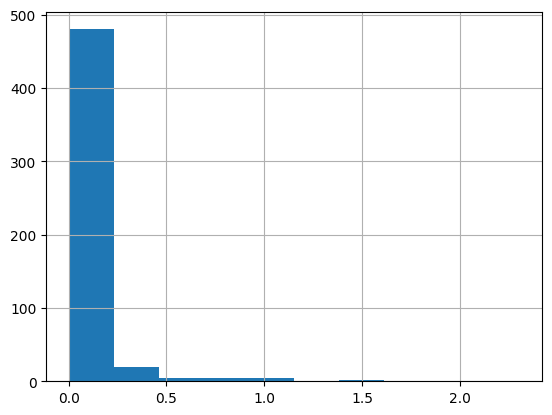

In [120]:
candidates.score.hist();

In [123]:
for i in range(10):
    cluster_size = len(candidates[candidates["cluster"]==i])
    if cluster_size < 10: 
        continue
    print("\n--------\ncluster", str(i) ,": ", cluster_size,"repo(s) \n")
    print(candidates[candidates["cluster"] == i][features].median())


--------
cluster 0 :  380 repo(s) 

repo_stargazers_count          55.000000
repo_forks_count               16.000000
repo_size                    4568.000000
repo_subscribers_count          5.000000
repo_open_issues_count          2.000000
repo_years_since_creation       3.291781
owner_followers                33.000000
owner_public_repos             22.500000
orga_followers                 17.000000
orga_public_repos              25.000000
dtype: float64

--------
cluster 5 :  108 repo(s) 

repo_stargazers_count          75.00000
repo_forks_count               20.50000
repo_size                    1570.50000
repo_subscribers_count          9.00000
repo_open_issues_count          3.00000
repo_years_since_creation       7.60411
owner_followers                27.00000
owner_public_repos             24.50000
orga_followers                  7.00000
orga_public_repos              28.00000
dtype: float64


In [124]:
candidates.repo_stargazers_count.quantile(0.7)

151.79999999999995

In [125]:
candidates[candidates.repo_full_name.str.contains("opendp")]

,repo_id,repo_full_name,repo_stargazers_count,repo_watchers_count,repo_description,repo_topics,repo_forks_count,repo_language,repo_visibility,repo_subscribers_count,repo_open_issues_count,repo_created_at,repo_last_modified,repo_has_projects,repo_has_wiki,repo_has_downloads,repo_size,repo_raw_data,owner_id,owner_name,owner_login,owner_type,owner_bio,owner_company,owner_role,owner_email,owner_followers,owner_following,owner_location,owner_total_private_repos,owner_public_repos,owner_team_count,owner_twitter_username,owner_created_at,owner_updated_at,owner_raw_data,orga_id,orga_name,orga_login,orga_type,orga_description,orga_company,orga_email,orga_followers,orga_following,orga_location,orga_total_private_repos,orga_public_repos,orga_collaborators,orga_created_at,orga_updated_at,orga_blog,orga_raw_data,taxo_category,query,score,repo_years_since_creation,cluster
141,210420701,opendp/smartnoise-sdk,166,166,Tools and service for differentially private p...,"['differential-privacy', 'opendp', 'privacy', ...",41,Python,public,24,19,2019-09-23 18:06:00,"Wed, 19 Oct 2022 11:35:49 GMT",True,True,True,40753,"{'id': 210420701, 'node_id': 'MDEwOlJlcG9zaXRv...",74011960,OpenDP,opendp,Organization,Open Differential Privacy,NaN,NaN,info@opendp.org,47,0,NaN,NaN,25,NaN,opendp_org,2020-11-05 16:14:59,2021-07-16 14:14:56,"{'login': 'opendp', 'id': 74011960, 'node_id':...",74011960.0,OpenDP,opendp,Organization,NaN,NaN,info@opendp.org,47.0,0.0,NaN,NaN,25.0,NaN,2020-11-05 16:14:59,2021-07-16 14:14:56,http://opendp.org/,"{'login': 'opendp', 'id': 74011960, 'node_id':...",privacy,data privacy,0.035202,3.087671,0


In [126]:
candidates[(candidates.cluster == 0) & (candidates.repo_stargazers_count > 25) & (candidates.score > candidates.score.quantile(0.7))].head(50)

,repo_id,repo_full_name,repo_stargazers_count,repo_watchers_count,repo_description,repo_topics,repo_forks_count,repo_language,repo_visibility,repo_subscribers_count,repo_open_issues_count,repo_created_at,repo_last_modified,repo_has_projects,repo_has_wiki,repo_has_downloads,repo_size,repo_raw_data,owner_id,owner_name,owner_login,owner_type,owner_bio,owner_company,owner_role,owner_email,owner_followers,owner_following,owner_location,owner_total_private_repos,owner_public_repos,owner_team_count,owner_twitter_username,owner_created_at,owner_updated_at,owner_raw_data,orga_id,orga_name,orga_login,orga_type,orga_description,orga_company,orga_email,orga_followers,orga_following,orga_location,orga_total_private_repos,orga_public_repos,orga_collaborators,orga_created_at,orga_updated_at,orga_blog,orga_raw_data,taxo_category,query,score,repo_years_since_creation,cluster
13,206106232,hukkelas/DeepPrivacy,1167,1167,DeepPrivacy: A Generative Adversarial Network ...,[],175,Python,public,29,1,2019-09-03 15:08:27,"Thu, 20 Oct 2022 04:46:49 GMT",True,True,True,12899,"{'id': 206106232, 'node_id': 'MDEwOlJlcG9zaXRv...",10548899,Håkon Hukkelås,hukkelas,User,"Interested in generative models, autonomous ve...","PhD Candidate, NTNU",NaN,hakon.hukkelas@ntnu.no,129,12,"Trondheim, Norway",NaN,54,NaN,NaN,2015-01-15 15:32:06,2022-09-28 11:27:31,"{'login': 'hukkelas', 'id': 10548899, 'node_id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,privacy,privacy,0.048613,3.142466,0
22,152788528,usnistgov/PrivacyEngCollabSpace,152,152,Privacy Engineering Collaboration Space,"['de-identification', 'differential-privacy', ...",93,Python,public,36,2,2018-10-12 17:53:40,"Sun, 16 Oct 2022 14:29:05 GMT",True,True,True,26129,"{'id': 152788528, 'node_id': 'MDEwOlJlcG9zaXRv...",5330158,National Institute of Standards and Technology,usnistgov,Organization,Department of Commerce,NaN,NaN,NaN,209,0,"Gaithersburg, Md.",NaN,986,NaN,NaN,2013-08-28 13:26:03,2022-05-02 16:54:27,"{'login': 'usnistgov', 'id': 5330158, 'node_id...",5330158.0,National Institute of Standards and Technology,usnistgov,Organization,NaN,NaN,NaN,209.0,0.0,"Gaithersburg, Md.",NaN,986.0,NaN,2013-08-28 13:26:03,2022-05-02 16:54:27,https://www.nist.gov,"{'login': 'usnistgov', 'id': 5330158, 'node_id...",privacy,privacy,0.164196,4.035616,0
23,231104091,undergroundwires/privacy.sexy,1835,1835,Open-source tool to enforce privacy & security...,"['bloatware', 'bloatware-removal', 'cleanup', ...",93,TypeScript,public,35,51,2019-12-31 14:38:28,"Thu, 20 Oct 2022 11:46:09 GMT",True,True,True,12192,"{'id': 231104091, 'node_id': 'MDEwOlJlcG9zaXRv...",15555035,NaN,undergroundwires,User,NaN,NaN,NaN,NaN,220,6,NaN,NaN,20,NaN,NaN,2015-11-01 10:56:39,2022-10-12 16:20:55,"{'login': 'undergroundwires', 'id': 15555035, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,privacy,privacy,0.054010,2.816438,0
33,235434204,benbusby/whoogle-search,6444,6444,"A self-hosted, ad-free, privacy-respecting met...","['adblock', 'docker', 'easy-deploy', 'flask', ...",696,Python,public,88,46,2020-01-21 20:22:33,"Wed, 19 Oct 2022 21:33:48 GMT",True,True,True,2284,"{'id': 235434204, 'node_id': 'MDEwOlJlcG9zaXRv...",33362396,Ben Busby,benbusby,User,NaN,@bstaero,NaN,contact@benbusby.com,175,0,Colorado,NaN,24,NaN,NaN,2017-11-04 00:12:05,2022-10-18 18:14:22,"{'login': 'benbusby', 'id': 33362396, 'node_id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,privacy,privacy,0.160310,2.756164,0
55,358607805,djyde/cusdis,2047,2047,"lightweight, privacy-friendly alternative to D...","['comment-system', 'disqus']",136,TypeScript,public,14,73,2021-04-16 13:26:27,"Thu, 20 Oct 2022 02:41:34 GMT",True,True,True,5961,"{'id': 358607805, 'node_id': 'MDEwOlJlcG9zaXRv...",914329,Randy,djyde,User,Love coding.\r\n\r\nTwitter: @randyloop,Microsoft,NaN,randypriv@gmail.com,2178,90,"Guangzhou, China",NaN,249,NaN,randyloop,2011-07-14 05:58:22,2022-10-20 11:20:57,"{'login': 'djyde', 'id': 914329, 'node_id': 'M...

In [128]:
#show descriptions 
for e in candidates[candidates["cluster"] == 0].repo_description.head(100).values:
    print(e,"\n\n------")

DeepPrivacy: A Generative Adversarial Network for Face Anonymization 

------
Privacy Engineering Collaboration Space 

------
Open-source tool to enforce privacy & security best-practices on Windows and macOS, because privacy is sexy 🍑🍆 

------
A self-hosted, ad-free, privacy-respecting metasearch engine 

------
nan 

------
lightweight, privacy-friendly alternative to Disqus. 

------
Dataflow analysis & differential privacy for SQL queries. This project is deprecated and not maintained. 

------
A web privacy measurement platform 

------
A Simulator for Privacy Preserving Federated Learning 

------
The Python Differential Privacy Library. Built on top of: https://github.com/google/differential-privacy 

------
A novel cryptocurrency focused on privacy and accessibility. 

------
Privacy Testing for Deep Learning 

------
A Privacy-Preserving Framework Based on TensorFlow 

------
A Dead Simple VPN. 

------
screen sharing for developers https://screego.net/ 

------
A privacy-fr

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(pd.DataFrame(X, columns=features).corr());

ModuleNotFoundError: No module named 'seaborn'

In [736]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
pca.explained_variance_ratio_

array([9.99938353e-01, 4.75915084e-05])

In [669]:
np.max(components[:, 1])

15.8273992512581

In [671]:

pca_res = pd.DataFrame(components, columns=["pc_1", "pc_2"], index=candidates.index)
candidates.merge(pca_res, left_index=True, right_index=True)

,repo_id,repo_full_name,repo_stargazers_count,repo_watchers_count,repo_description,repo_topics,repo_forks_count,repo_language,repo_visibility,repo_subscribers_count,repo_open_issues_count,repo_created_at,repo_last_modified,repo_has_projects,repo_has_wiki,repo_has_downloads,repo_size,repo_raw_data,owner_id,owner_name,owner_login,owner_type,owner_bio,owner_company,owner_role,owner_email,owner_followers,owner_following,owner_location,owner_total_private_repos,owner_public_repos,owner_team_count,owner_twitter_username,owner_created_at,owner_updated_at,owner_raw_data,orga_id,orga_name,orga_login,orga_type,orga_description,orga_company,orga_email,orga_followers,orga_following,orga_location,orga_total_private_repos,orga_public_repos,orga_collaborators,orga_created_at,orga_updated_at,orga_blog,orga_raw_data,taxo_category,query,score,pc_1,pc_2
14,12888993,home-assistant/core,55382,55382,:house_with_garden: Open source home automatio...,"[asyncio, hacktoberfest, home-automation, inte...",20085,Python,public,1346,2066,2013-09-17 07:29:48,"Thu, 20 Oct 2022 09:03:16 GMT",True,False,True,386972,"{'id': 12888993, 'node_id': 'MDEwOlJlcG9zaXRvc...",13844975,Home Assistant,home-assistant,Organization,Open source home automation that puts local co...,None,None,hello@home-assistant.io,1785,0,Your home,None,92,None,home_assistant,2015-08-18 04:27:28,2022-10-04 11:17:05,"{'login': 'home-assistant', 'id': 13844975, 'n...",13844975.0,Home Assistant,home-assistant,Organization,None,None,hello@home-assistant.io,1785.0,0.0,Your home,None,92.0,None,2015-08-18 04:27:28,2022-10-04 11:17:05,https://www.home-assistant.io,"{'login': 'home-assistant', 'id': 13844975, 'n...",privacy,privacy,2.110656,19.325887,-0.179897
60,35866694,RocketChat/Rocket.Chat,33586,33586,The communications platform that puts data pro...,"[chat, collaboration, foss, free, hacktoberfes...",7667,TypeScript,public,904,3504,2015-05-19 07:36:09,"Thu, 20 Oct 2022 09:54:06 GMT",True,True,True,634618,"{'id': 35866694, 'node_id': 'MDEwOlJlcG9zaXRvc...",12508788,Rocket.Chat,RocketChat,Organization,The communications platform that puts data pro...,None,None,None,366,0,None,None,237,None,None,2015-05-19 07:33:29,2022-02-18 13:58:03,"{'login': 'RocketChat', 'id': 12508788, 'node_...",12508788.0,Rocket.Chat,RocketChat,Organization,None,None,None,366.0,0.0,None,None,237.0,None,2015-05-19 07:33:29,2022-02-18 13:58:03,https://rocket.chat,"{'login': 'RocketChat', 'id': 12508788, 'node_...",privacy,data protection,1.110776,13.788204,-0.541126
202,242097396,PacktPublishing/Hands-On-Explainable-AI-XAI-wi...,104,104,"Explainable AI with Python, published by Packt",[],56,Jupyter Notebook,public,9,3,2020-02-21 09:05:25,"Sun, 16 Oct 2022 18:34:44 GMT",False,True,True,44944,"{'id': 242097396, 'node_id': 'MDEwOlJlcG9zaXRv...",10974906,Packt,PacktPublishing,Organization,"Providing books, eBooks, video tutorials, and ...",None,None,None,3306,0,"Birmingham, UK",None,7310,None,PacktPublishing,2015-02-12 10:36:37,2022-06-20 12:49:49,"{'login': 'PacktPublishing', 'id': 10974906, '...",10974906.0,Packt,PacktPublishing,Organization,None,None,None,3306.0,0.0,"Birmingham, UK",None,7310.0,None,2015-02-12 10:36:37,2022-06-20 12:49:49,https://www.packt.com,"{'login': 'PacktPublishing', 'id': 10974906, '...",transparency,Explainable AI,1.101402,0.148756,15.827399
221,144536553,llSourcell/OpenAI_Five_vs_Dota2_Explained,130,130,"This is the code for ""OpenAI Five vs DOTA 2 Ex...",[],25,Python,public,12,1,2018-08-13 06:09:49,"Wed, 21 Sep 2022 12:45:19 GMT",True,True,True,359,"{'id': 144536553, 'node_id': 'MDEwOlJlcG9zaXRv...",1279609,Siraj Raval,llSourcell,User,subscribe to my youtube channel! \r\nwww.youtu...,None,None,None,36247,4,"San Francisco, CA",None,446,None,None,2011-12-22 09:57:32,2022-08-24 16:23:15,"{'login': 'llSourcell', 'id': 1279609, 'node_i...",NaN,None,None,None,None,None,None,NaN,NaN,None,None,NaN,None,NaT,NaT,None,None,transparency,Explainable AI,1.064363,-0.216797,2.820358
213,188701024,andreysharapov/xaien

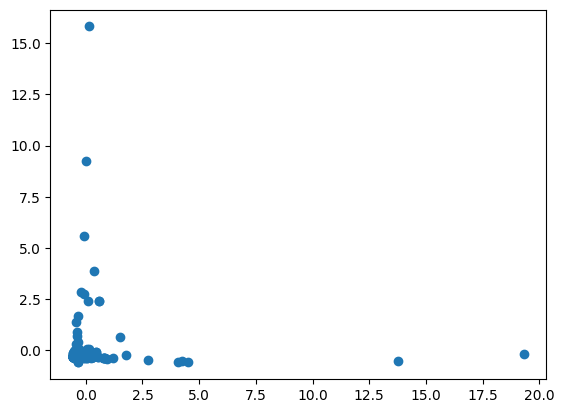

In [627]:
plt.scatter(components[:, 0], components[:, 1])

# HUGGING FACE

In [ ]:
! pip install huggingface_hub


In [2]:
from huggingface_hub import HfApi
api = HfApi()


In [4]:
len(api.list_models())

77781

In [57]:
api.list_models(search="privacy")

[ModelInfo: {
 	modelId: pile-of-law/distilbert-base-uncased-finetuned-eoir_privacy
 	sha: None
 	lastModified: None
 	tags: None
 	pipeline_tag: text-classification
 	siblings: None
 	private: False
 	author: None
 	config: None
 	securityStatus: None
 	id: pile-of-law/distilbert-base-uncased-finetuned-eoir_privacy
 },
 ModelInfo: {
 	modelId: momo/KcELECTRA-base_Hate_speech_Privacy_Detection
 	sha: None
 	lastModified: None
 	tags: None
 	pipeline_tag: text-classification
 	siblings: None
 	private: False
 	author: None
 	config: None
 	securityStatus: None
 	id: momo/KcELECTRA-base_Hate_speech_Privacy_Detection
 },
 ModelInfo: {
 	modelId: momo/KcBERT-base_Hate_speech_Privacy_Detection
 	sha: None
 	lastModified: None
 	tags: None
 	pipeline_tag: text-classification
 	siblings: None
 	private: False
 	author: None
 	config: None
 	securityStatus: None
 	id: momo/KcBERT-base_Hate_speech_Privacy_Detection
 },
 ModelInfo: {
 	modelId: muhtasham/bert-small-finetuned-eoir_privacy
 	sha: 

In [5]:
len(api.list_datasets())

11748

In [58]:
api.list_datasets(search="privacy")

[DatasetInfo: {
 	id: arjunth2001/online_privacy_qna
 	sha: c633b5c257a7adc28f782b1d5c5b60f9f391a31f
 	lastModified: 2021-11-10T08:53:10.000Z
 	tags: []
 	private: False
 	author: arjunth2001
 	description: None
 	citation: None
 	cardData: None
 	siblings: None
 	gated: False
 	downloads: 320
 },
 DatasetInfo: {
 	id: ceyda/test-privacy
 	sha: bafeb849715ae4aef0cd99fb2b82b4a7d8f31f95
 	lastModified: 2022-04-25T08:36:19.000Z
 	tags: ['license:other']
 	private: False
 	author: ceyda
 	description: None
 	citation: None
 	cardData: None
 	siblings: None
 	gated: True
 	downloads: 2
 },
 DatasetInfo: {
 	id: pile-of-law/eoir_privacy
 	sha: 212b8789f3958e28a961b7147be3c52b83992918
 	lastModified: 2022-07-07T08:44:32.000Z
 	tags: ['arxiv:2207.00220', 'language_creators:found', 'language:en', 'license:cc-by-nc-sa-4.0', 'multilinguality:monolingual', 'pretty_name:eoir_privacy', 'task_categories:text-classification']
 	private: False
 	author: pile-of-law
 	description: A living legal dataset

In [7]:
len(api.list_spaces())

13499

In [8]:
len(api.list_metrics())

85

In [50]:
len(api.list_repo_files("distilbert-base-uncased-finetuned-sst-2-english"))

9

In [10]:
from huggingface_hub import ModelSearchArguments, DatasetSearchArguments, 

model_args = ModelSearchArguments()
dataset_args = DatasetSearchArguments()

In [43]:
model_args.pipeline_tag

Available Attributes or Keys:
 * AudioClassification
 * Audio_to_Audio
 * AutomaticSpeechRecognition
 * Conversational
 * DocumentQuestionAnswering
 * FeatureExtraction
 * Fill_Mask
 * ImageClassification
 * ImageSegmentation
 * Image_to_Image
 * Image_to_Text
 * ObjectDetection
 * QuestionAnswering
 * ReinforcementLearning
 * Robotics
 * SentenceSimilarity
 * Summarization
 * TableQuestionAnswering
 * TabularClassification
 * TabularRegression
 * Text2TextGeneration (Key only)
 * TextClassification
 * TextGeneration
 * Text_to_Image
 * Text_to_Speech
 * TokenClassification
 * Translation
 * UnconditionalImageGeneration
 * VisualQuestionAnswering
 * VoiceActivityDetection
 * Zero_ShotClassification
 * Zero_ShotImageClassification

In [47]:
from huggingface_hub import ModelFilter, DatasetFilter

filt = ModelFilter(
    task=model_args.pipeline_tag.TextClassification, 
    trained_dataset=dataset_args.dataset_name.glue, 
#    library=model_args.library.PyTorch
)
api.list_models(filter=filt)[0]

ModelInfo: {
	modelId: distilbert-base-uncased-finetuned-sst-2-english
	sha: 324d3097568e82724d53d7ac1d312aa719d48037
	lastModified: 2022-08-16T13:26:26.000Z
	tags: ['pytorch', 'tf', 'rust', 'distilbert', 'text-classification', 'en', 'dataset:sst2', 'dataset:glue', 'transformers', 'license:apache-2.0', 'model-index']
	pipeline_tag: text-classification
	siblings: [RepoFile(rfilename='.gitattributes', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='README.md', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='config.json', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='map.jpeg', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='pytorch_model.bin', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='rust_model.ot', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='tf_model.h5', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='tokenizer_config.json', size='None', blob_id='None', lfs='None'), RepoFile(r

In [48]:
api.model_info("distilbert-base-uncased-finetuned-sst-2-english")

ModelInfo: {
	modelId: distilbert-base-uncased-finetuned-sst-2-english
	sha: 324d3097568e82724d53d7ac1d312aa719d48037
	lastModified: 2022-08-16T13:26:26.000Z
	tags: ['pytorch', 'tf', 'rust', 'distilbert', 'text-classification', 'en', 'dataset:sst2', 'dataset:glue', 'transformers', 'license:apache-2.0', 'model-index']
	pipeline_tag: text-classification
	siblings: [RepoFile(rfilename='.gitattributes', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='README.md', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='config.json', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='map.jpeg', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='pytorch_model.bin', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='rust_model.ot', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='tf_model.h5', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='tokenizer_config.json', size='None', blob_id='None', lfs='None'), RepoFile(r

In [30]:
api.list_spaces(search="fairness")

[SpaceInfo: {
 	id: merve/measuring-fairness
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: static
 	likes: 1
 },
 SpaceInfo: {
 	id: fullyConnected/Fairness-detection
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: gradio
 },
 SpaceInfo: {
 	id: d4data/Bias-Fairness-in-AI
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: streamlit
 	runningSdkVersion: 1.10.0
 }]

Models:



Spaces:
* id
* sha
* lastModified
* repoFiles: Nb of file per type (.py, ...)? 
* private
* author
* likes
* cardData: 
    * title
    * license
    * app_file

* tags
* models
* sdk

In [31]:
api.space_info("merve/measuring-fairness")

SpaceInfo: {
	id: merve/measuring-fairness
	sha: 40559c4cbf1d919745ea367c986d2069a5a8fb90
	lastModified: 2022-04-28T12:41:58.000Z
	siblings: [RepoFile(rfilename='.gitattributes', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='.gitignore', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='CONTRIBUTING.md', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='LICENSE', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='README.md', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='index.html', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='package.json', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='public/anonymization/annotations.js', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='public/anonymization/index.html', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='public/anonymization/init.js', size='None', blob_id='None', lfs='None'), RepoFile(rfilename='public/anonymizat

In [19]:
api.list_spaces()

[SpaceInfo: {
 	id: 17651/TESR
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: streamlit
 },
 SpaceInfo: {
 	id: 17939225/cartest
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: streamlit
 },
 SpaceInfo: {
 	id: 52Hz/CMFNet_deblurring
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: gradio
 	likes: 13
 },
 SpaceInfo: {
 	id: 52Hz/CMFNet_dehazing
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: gradio
 	likes: 3
 },
 SpaceInfo: {
 	id: 52Hz/CMFNet_deraindrop
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: gradio
 	likes: 10
 },
 SpaceInfo: {
 	id: 52Hz/HWMNet_lowlight_enhancement
 	sha: None
 	lastModified: None
 	siblings: None
 	private: False
 	author: None
 	sdk: gradio
 	likes: 6
 },
 SpaceInfo: {
 	id: 52Hz/SRMNet_AWGN_denoising
 	sha: None
 	lastModified: None
 	siblings: None
 	p

In [18]:
api.get_model_tags()

Available Attributes or Keys:
 * dataset
 * language
 * library
 * license
 * pipeline_tag

task_categories: 
- InclusiveLanguage
- moral_reasoning

In [54]:
from huggingface_hub import users

ImportError: cannot import name 'users' from 'huggingface_hub' (/Users/khemon/Documents/Pro/projects/mozilla/mozilla_env/lib/python3.10/site-packages/huggingface_hub/__init__.py)

In [17]:
model_args.pipeline_tag

Available Attributes or Keys:
 * AudioClassification
 * Audio_to_Audio
 * AutomaticSpeechRecognition
 * Conversational
 * DocumentQuestionAnswering
 * FeatureExtraction
 * Fill_Mask
 * ImageClassification
 * ImageSegmentation
 * Image_to_Image
 * Image_to_Text
 * ObjectDetection
 * QuestionAnswering
 * ReinforcementLearning
 * Robotics
 * SentenceSimilarity
 * Summarization
 * TableQuestionAnswering
 * TabularClassification
 * TabularRegression
 * Text2TextGeneration (Key only)
 * TextClassification
 * TextGeneration
 * Text_to_Image
 * Text_to_Speech
 * TokenClassification
 * Translation
 * UnconditionalImageGeneration
 * VisualQuestionAnswering
 * VoiceActivityDetection
 * Zero_ShotClassification
 * Zero_ShotImageClassification

In [14]:
dataset_args.task_categories

Available Attributes or Keys:
 * Automatic_Speech_Recognition
 * CodeGeneration
 * Evaluationoflanguagemodels
 * ImitationLearning
 * InclusiveLanguage
 * InformationRetrieval
 * Language_model
 * MultiLabelTextClassification
 * SemanticSearch
 * Summarization
 * Text2Textgeneration (Key only)
 * TextNeutralization
 * TokenClassification
 * Translation
 * abstractive_qa
 * audio_classification
 * automatic_speech_recognition
 * caption_retrieval
 * classification
 * closed_domain_abstrative_qa
 * code_generation
 * commonsense_generation
 * commonsense_reasoning
 * commonsensereasoning
 * computer_vision
 * conditional_text_generation
 * conversational
 * coreferenceresolution
 * cross_language_transcription
 * crowdsourced
 * data_integration
 * data_to_text
 * deduplication
 * dialog_response_generation
 * emailsubject
 * entity_extraction
 * extractive_qa
 * feature_extraction
 * fill_mask
 * generative_modelling
 * gpt_3 (Key only)
 * grammaticalerrorcorrection
 * image
 * image_ca